In [19]:
INPUT_CTX_PATH = "input/ctx"
FEATURE_PATH = "input/feature"
OUTPUT_PATH = "output"

In [4]:
from torch import cuda, bfloat16
import torch
import transformers
from transformers import AutoTokenizer
from time import time
# import chromadbsl
#from chromadb.config import Settings
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma
import os
import openai
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Initialize model, tokenizer, query pipeline

Define the model, the device, and the `bitsandbytes` configuration.

In [9]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 4.0 MB/s eta 0:00:0000:01


In [23]:
import docx
import base64


def handledocx(filepath):
    doc = docx.Document(filepath)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    resp = {
      "type": "text",
      "text": '\n'.join(fullText)
    }
    return resp


def handlepng(filepath):

    with open(filepath, "rb") as image_file:
         base64_image = base64.b64encode(image_file.read()).decode('utf-8')
    
    resp =   {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
          }
    }
    return resp
    

In [30]:
import os

# print(os.listdir(INPUT_PATH))
supported_files = {
    "png": handlepng,
    # "pdf": "handlepdf",
    "docx": handledocx,
    # "txt": "handle txt",
}




def getcontent(path):
    content = []
    input_files = [f for f in os.listdir(path) if os.path.isfile(f'{path}/{f}')]
    
    for i in input_files:
    
        ext = i.split(".")[-1]
        try:
            inp = supported_files[ext](f'{path}/{i}')
            content.append(inp)
        except Exception as e:
            print(f"unsupported file type, {i}, {e}")
    return content

def promptobj(prompt):
    return {
      "type": "text",
      "text": prompt
    }

pre_prompt = promptobj("You are a product tester who will write test cases for the following project.")

ctx_content = getcontent(INPUT_CTX_PATH)

mid_prompt = promptobj("For the above product we are building a new feature with the below description.")

feature_content = getcontent(FEATURE_PATH)

end_prompt = promptobj("Generate 50 test cases for this new feature of the format, (test_case_name, test_case_description) for this products. Do not say anything else. Only provide csv compatible text output")


[{'type': 'image_url',
  'image_url': {'url': ''}},
 {'type': 'text',
  'text': "VR Immersive Dialogue Practice for Real-Life Language Learning\n\nProject Summary:\n\nThis feature will allow users to enter VR environments simulating real-world scenarios where they can practice the dialogues they've recorded throughout their day. It will utilize AI and NLP (Natural Language Processing) techniques to provide targeted feedback, conversational practice, and immersive learning experiences.\n\nProblem Statement:\n\nTraditional language learning often lacks realistic conversational practice and integration into daily routines. This VR feature aims to bridge the gap between studying and real-world application for accelerated language learning.\n\nObjectives:\n\nImmersive Practice: Create realistic VR environments that simulate common scenarios for language use (ordering coffee, asking for directions, workplace conversations, etc.).\nAI-Powered Conversation Partner: Develop an AI conversational
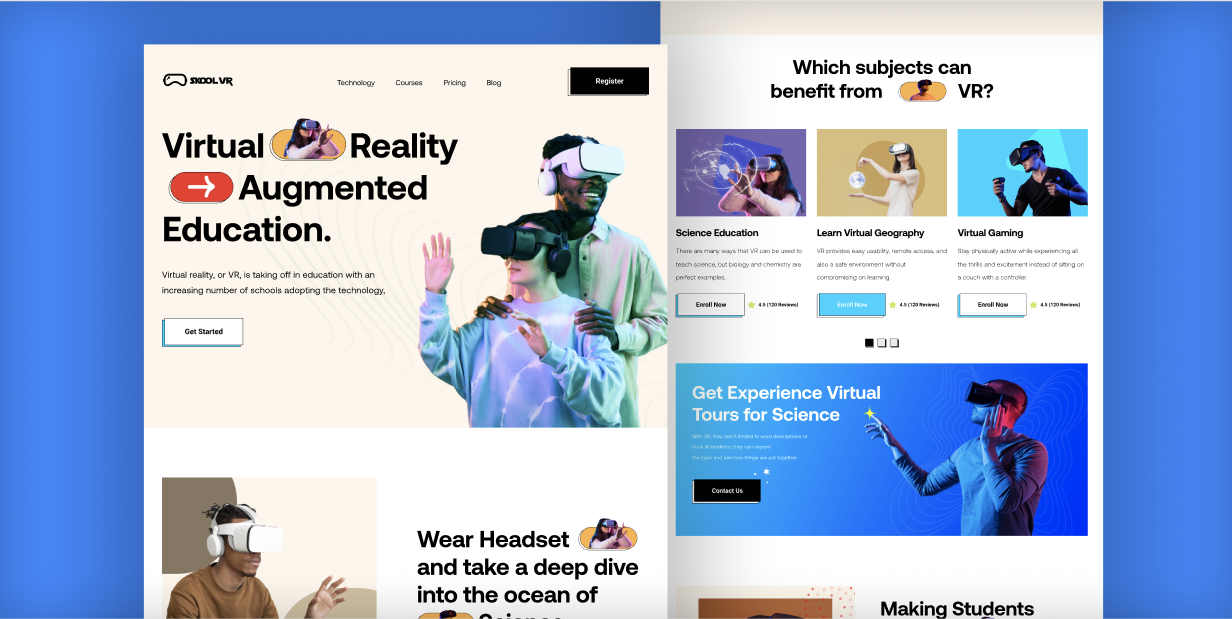

{'model': 'gpt-4-vision-preview', 'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'You are a product tester who will write test cases for the following project.'}, {'type': 'text', 'text': "Phase 1: Immersive Language Teacher\nTL;DR\nThere are two types of language learning applications in the market, one is using studying materials made by real people (videos, audios, texts, slides, etc), the other is to chat with AI in a pseudo scenario. However, they all require learners to devote a specific time and practice using materials that are not 100% suitable for them. \nWe are building software that records your daily dialogue, and provides feedback on your real life dialogue. Based on the real chat, users will enjoy a 10x efficiency boost compared to any other solutions. We integrate seamlessly into users' daily lives without requiring dedicated study time.\nMarket Research\nAs of February 22, 2024, there are no similar tools in the market. \nAs of February 22, 2024, Du
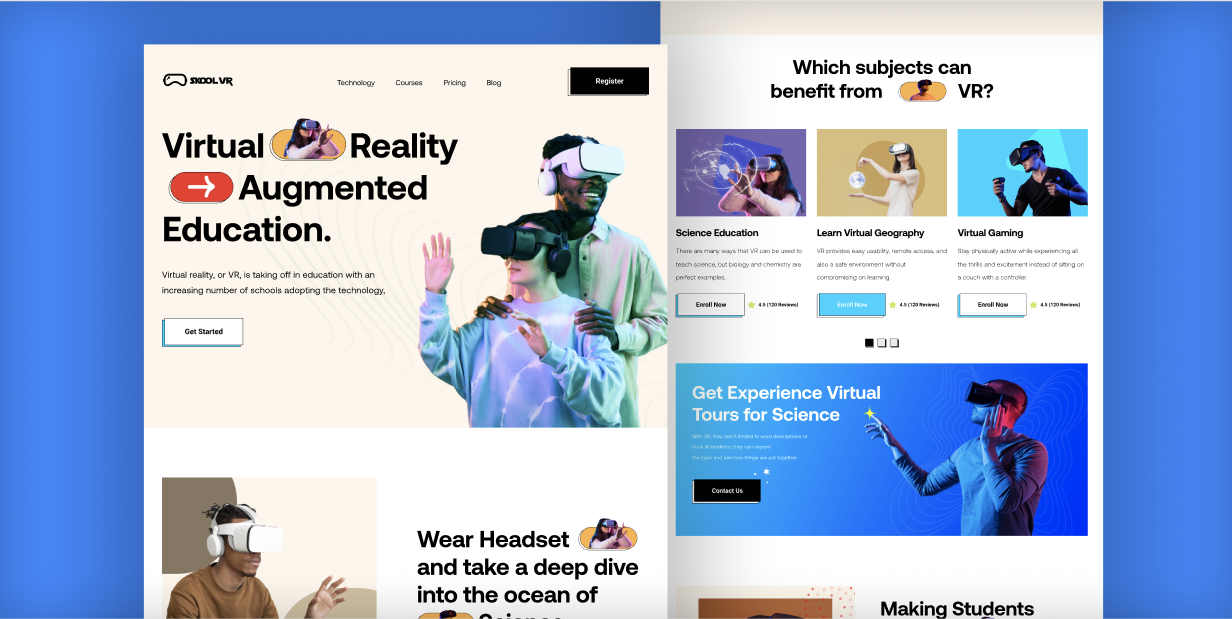

In [32]:
import base64
import requests

# OpenAI API Key
api_key = '<Enter API key hereg>'

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "path_to_your_image.jpg"



headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}



payload = {
  "model": "gpt-4-vision-preview",
  "messages": [
    {
      "role": "user",
      "content": [pre_prompt,*ctx_content, mid_prompt, *feature_content, end_prompt]
    }
  ],
  "max_tokens": 300
}

# print(payload)

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())
    

In [36]:
import datetime

now = datetime.datetime.now()

with open(f'{OUTPUT_PATH}/output.csv', "w+") as f:
    f.write(response.json()['choices'][0]['message']['content'])

In [7]:
os.environ["OPENAI_API_KEY"] = '<OPENAI API KEY>'
# 
# EMBEDDING_MODEL = "text-embedding-3-small"
# 
# embedding_function = OpenAIEmbeddingFunction(api_key=os.environ.get('OPENAI_API_KEY'), model_name=EMBEDDING_MODEL)


In [6]:
# !ls /kaggle/input/llama-2/pytorch/7b-chat-hf/1

In [18]:
# model_id = '/kaggle/input/llama-2/pytorch/7b-chat-hf/1'
# 
# device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
# 
# # set quantization configuration to load large model with less GPU memory
# # this requires the `bitsandbytes` library
# bnb_config = transformers.BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type='nf4',
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_compute_dtype=bfloat16
# )

Prepare the model and the tokenizer.

In [20]:
# time_1 = time()
# model_config = transformers.AutoConfig.from_pretrained(
#     model_id,
# )
# model = transformers.AutoModelForCausalLM.from_pretrained(
#     model_id,
#     trust_remote_code=True,
#     config=model_config,
#     quantization_config=bnb_config,
#     device_map='auto',
# )
# tokenizer = AutoTokenizer.from_pretrained(model_id)
# time_2 = time()
# print(f"Prepare model, tokenizer: {round(time_2-time_1, 3)} sec.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


Prepare model, tokenizer: 118.913 sec.


Define the query pipeline.

In [21]:
time_1 = time()
query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        device_map="auto",)
time_2 = time()
print(f"Prepare pipeline: {round(time_2-time_1, 3)} sec.")

Prepare pipeline: 1.703 sec.


We define a function for testing the pipeline.

In [22]:
def get_output(tokenizer, pipeline, prompt_to_test):
    """
    Perform a query
    print the result
    Args:
        tokenizer: the tokenizer
        pipeline: the pipeline
        prompt_to_test: the prompt
    Returns
        None
    """
    # adapted from https://huggingface.co/blog/llama2#using-transformers
    time_1 = time()
    sequences = pipeline(
        prompt_to_test,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=200,)
    time_2 = time()
    print(f"Test inference: {round(time_2-time_1, 3)} sec.")
    for seq in sequences:
        print(f"Result: {seq['generated_text']}")

## Test the query pipeline

We test the pipeline with a query about the meaning of State of the Union (SOTU).

In [23]:
get_output(tokenizer,
           query_pipeline,
           "Please explain what is the State of the Union address. Give just a definition. Keep it in 100 words.")

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


Test inference: 7.588 sec.
Result: Please explain what is the State of the Union address. Give just a definition. Keep it in 100 words.
The State of the Union address is an annual speech given by the President of the United States to a joint session of Congress, typically held in February or March, in which the President reviews the current state of affairs in the country and presents legislative proposals and policy initiatives for the upcoming year.


In [40]:
import csv
from itertools import islice

cfp = "/kaggle/input/amazon-test/amcm.csv"

import csv
from itertools import islice


with open(cfp, encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    for row in islice(reader,1,3):
        template = """Task: I will give you a product review from Amazon and you will have to tell me if that string contains potentially medically sensitive information and help me rephrase it if so.

            Input: %s

            Output: A JSON String containing 3 keys, nothing else.
            "sensitive" as boolean value indicating whether it contains potentially medically sensitive information.

            "rephrasing" as a string which contains the original string to be without privacy infringing information, don't modify unrelated words. If not sensitive, keep it blank.

            "reason" as a string with exact copy of the sensitive part from the original sentence and brief explanation. If not sensitive, keep it blank.
            """
#         print(row[3])
        print(get_output(tokenizer, query_pipeline, template.format(row[3])))



Test inference: 4.065 sec.
Result: Task: I will give you a product review from Amazon and you will have to tell me if that string contains potentially medically sensitive information and help me rephrase it if so.

            Input: %s

            Output: A JSON String containing 3 keys, nothing else.
            "sensitive" as boolean value indicating whether it contains potentially medically sensitive information.

            "rephrasing" as a string which contains the original string to be without privacy infringing information, don't modify unrelated words. If not sensitive, keep it blank.

            "reason" as a string with exact copy of the sensitive part from the original sentence and brief explanation. If not sensitive, keep it blank.
            
Example:
{
"sensitive": true,
"rephrasing": "Find out how this product can help you achieve the best results with minimal effort.",
"reason": "This sentence
None
Test inference: 4.035 sec.
Result: Task: I will give you a product

# Retrieval Augmented Generation

## Check the model with a HuggingFace pipeline


We check the model with a HF pipeline, using a query about the meaning of State of the Union (SOTU).

In [15]:
llm = HuggingFacePipeline(pipeline=query_pipeline)
# checking again that everything is working fine
llm(prompt="Please explain what is the State of the Union address. Give just a definition. Keep it in 100 words.")

'\nThe State of the Union address is an annual speech given by the President of the United States to a joint session of Congress, in which the President reports on the current state of the union and outlines their legislative agenda for the upcoming year.'

## Ingestion of data using Text loder

We will ingest the newest presidential address, from Jan 2023.

In [9]:
loader = TextLoader("/kaggle/input/president-bidens-state-of-the-union-2023/biden-sotu-2023-planned-official.txt",
                    encoding="utf8")
documents = loader.load()

## Split data in chunks

We split data in chunks using a recursive character text splitter.

In [10]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)

## Creating Embeddings and Storing in Vector Store

Create the embeddings using Sentence Transformer and HuggingFace embeddings.

In [11]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

Initialize ChromaDB with the document splits, the embeddings defined previously and with the option to persist it locally.

In [12]:
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

## Initialize chain

In [16]:
retriever = vectordb.as_retriever()

qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)

## Test the Retrieval-Augmented Generation 


We define a test function, that will run the query and time it.

In [17]:
def test_rag(qa, query):
    print(f"Query: {query}\n")
    time_1 = time()
    result = qa.run(query)
    time_2 = time()
    print(f"Inference time: {round(time_2-time_1, 3)} sec.")
    print("\nResult: ", result)

Let's check few queries.

In [18]:
query = "What were the main topics in the State of the Union in 2023? Summarize. Keep it under 200 words."
test_rag(qa, query)

Query: What were the main topics in the State of the Union in 2023? Summarize. Keep it under 200 words.



> Entering new RetrievalQA chain...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


> Finished chain.
Inference time: 11.707 sec.

Result:   The State of the Union in 2023 focused on several key topics, including the nation's economic strength, the competition with China, and the need to come together as a nation to face the challenges ahead. The President emphasized the importance of American innovation, industries, and military modernization to ensure the country's safety and stability. The President also highlighted the nation's resilience and optimism, urging Americans to see each other as fellow citizens and to work together to overcome the challenges facing the country.


In [19]:
query = "What is the nation economic status? Summarize. Keep it under 200 words."
test_rag(qa, query)

Query: What is the nation economic status? Summarize. Keep it under 200 words.



> Entering new RetrievalQA chain...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


> Finished chain.
Inference time: 10.555 sec.

Result:   The nation's economic status is strong, with a low unemployment rate of 3.4%, near record lows for Black and Hispanic workers, and fastest growth in 40 years in manufacturing jobs. The president highlights the progress made in creating good-paying jobs, exporting American products, and reducing inflation. However, the president acknowledges there is still more work to be done to fully recover from the pandemic and Putin's war.


## Document sources

Let's check the documents sources, for the last query run.

In [ ]:
docs = vectordb.similarity_search(query)
print(f"Query: {query}")
print(f"Retrieved documents: {len(docs)}")
for doc in docs:
    doc_details = doc.to_json()['kwargs']
    print("Source: ", doc_details['metadata']['source'])
    print("Text: ", doc_details['page_content'], "\n")

# Conclusions


We used Langchain, ChromaDB and Llama 2 as a LLM to build a Retrieval Augmented Generation solution. For testing, we were using the latest State of the Union address from Jan 2023.


# More work on the same topic

You can find more details about how to use a LLM with Kaggle. Few interesting topics are treated in:  

* https://www.kaggle.com/code/gpreda/test-llama-2-quantized-with-llama-cpp (quantizing LLama 2 model using llama.cpp)
* https://www.kaggle.com/code/gpreda/fast-test-of-llama-v2-pre-quantized-with-llama-cpp  (quantized Llamam 2 model using llama.cpp)  
* https://www.kaggle.com/code/gpreda/test-of-llama-2-quantized-with-llama-cpp-on-cpu (quantized model using llama.cpp - running on CPU)  
* https://www.kaggle.com/code/gpreda/explore-enron-emails-with-langchain-and-llama-v2 (Explore Enron Emails with Langchain and Llama v2)


# References  

[1] Murtuza Kazmi, Using LLaMA 2.0, FAISS and LangChain for Question-Answering on Your Own Data, https://medium.com/@murtuza753/using-llama-2-0-faiss-and-langchain-for-question-answering-on-your-own-data-682241488476  

[2] Patrick Lewis, Ethan Perez, et. al., Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks, https://browse.arxiv.org/pdf/2005.11401.pdf 

[3] Minhajul Hoque, Retrieval Augmented Generation: Grounding AI Responses in Factual Data, https://medium.com/@minh.hoque/retrieval-augmented-generation-grounding-ai-responses-in-factual-data-b7855c059322  

[4] Fangrui Liu	, Discover the Performance Gain with Retrieval Augmented Generation, https://thenewstack.io/discover-the-performance-gain-with-retrieval-augmented-generation/

[5] Andrew, How to use Retrieval-Augmented Generation (RAG) with Llama 2, https://agi-sphere.com/retrieval-augmented-generation-llama2/   

[6] Yogendra Sisodia, Retrieval Augmented Generation Using Llama2 And Falcon, https://medium.com/@scholarly360/retrieval-augmented-generation-using-llama2-and-falcon-ed26c7b14670   

